In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil

os.chdir('/content/drive/MyDrive/FYP/data')

# data_dir contains subfolders of the 7 labels
data_dir = os.getcwd() + "/reorganized/"


## Train-test split


In this section, we will
1. Splits the reorganized data into train and test sets
2. Stores the train and test sets in Google Drive (train_dir and test_dir)
3. Creates train, test and val tf.data.Dataset from image files in respective directory
4. Stores the val sets in Google Drive (val_dir)

Initial batch_size and image size

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
from sklearn.model_selection import train_test_split

train_dir = os.path.join(os.getcwd(), "split_data/train_data")
test_dir = os.path.join(os.getcwd(), "split_data/test_data")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


Store the train and test images into drive (each with 7 subfolders)

In [ ]:
# Check if train_dir or test_dir is empty
if not os.listdir(train_dir) or not os.listdir(test_dir):
    # 1: Split into training and test sets
    all_images = []
    for label in os.listdir(data_dir):
      label_dir = os.path.join(data_dir, label)
      images = [os.path.join(label_dir, img) for img in os.listdir(label_dir)]
      all_images.extend(images)

    train_images, test_images = train_test_split(all_images, test_size=0.2, random_state=42)
    # train_images will contain the file paths of images for training
    # test_images will contain the file paths of images for testing.

    # 2: Copy training images to train_dir
    for image_path in train_images:
        label = os.path.basename(os.path.dirname(image_path))
        dest_dir = os.path.join(train_dir, label)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy(image_path, dest_dir)

    # Copy test images to test_dir
    for image_path in test_images:
        label = os.path.basename(os.path.dirname(image_path))
        dest_dir = os.path.join(test_dir, label)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy(image_path, dest_dir)
else:
    print("'train_data' or 'test_data' directory is not empty. No files copied.")


'train_data' or 'test_data' directory is not empty. No files copied.


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8012 files belonging to 7 classes.
Using 6410 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8012 files belonging to 7 classes.
Using 1602 files for validation.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False  # No need to shuffle for testing/validation
)


Found 2003 files belonging to 7 classes.


Save the val_ds to drive

Move validation images from train_dir to val_dir



In [ ]:
val_dir = os.path.join(os.getcwd(), "val_data")
os.makedirs(val_dir, exist_ok=True)

In [ ]:
import os
import shutil

val_images = set(val_ds.file_paths)

# List all images in the train directory and its subdirectories
all_train_images = [os.path.join(root, img) for root, dirs, files in os.walk(train_dir) for img in files]

# Identify images in train_dir that also exist in val_ds
common_images = set(all_train_images).intersection(val_images)

# Check if val_dir is empty
if not os.listdir(val_dir):
    # Create subdirectories in val_dir if they don't exist
    for img_path in common_images:
        relative_path = os.path.relpath(img_path, train_dir)
        dest_path = os.path.join(val_dir, relative_path)

        # Ensure the subdirectory in val_dir exists
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)

        # Move identified images to val_dir
        shutil.move(img_path, dest_path)
        print(f"Moved {img_path} to {dest_path}")

    print(f"Number of images moved to {val_dir}: {len(common_images)}")
else:
    print(f"{val_dir} is not empty. No images moved.")


/content/drive/.shortcut-targets-by-id/1lclS-j0-aTtokJIp_S7_ncb6hqyunFAd/FYP/data/val_data is not empty. No images moved.


### Visualize the train set

In [ ]:
class_names = train_ds.class_names
print(class_names)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Here are the first nine images from the training dataset:

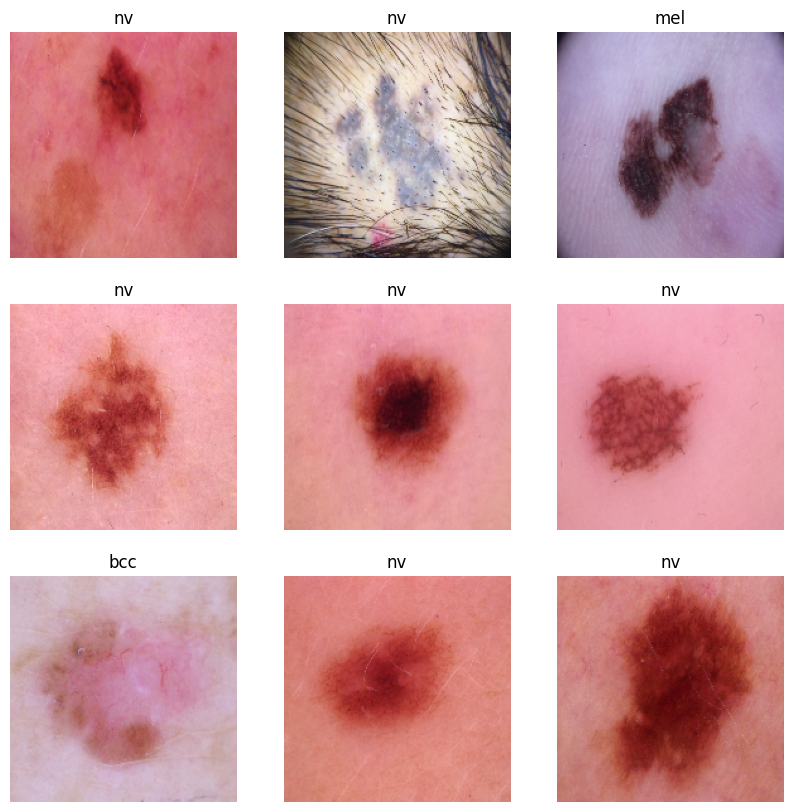

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Push split_data to 🤗

In [ ]:
split_dir = os.getcwd() + "/split_data"

In [ ]:
import huggingface_hub

In [ ]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login
notebook_login()


Before pushing to hub, an empty dataset named as originalSkin must be first created in my hugging face hub

In [ ]:
from datasets import load_dataset

dataset = load_dataset(split_dir)
dataset.push_to_hub("Sharren/originalSkin")

Resolving data files:   0%|          | 0/5128 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2884 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2003 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Uploading the dataset shards:   0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/1710 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/18 [00:00<?, ?ba/s]

Map:   0%|          | 0/1709 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/18 [00:00<?, ?ba/s]

Map:   0%|          | 0/1709 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/18 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/1442 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/15 [00:00<?, ?ba/s]

Map:   0%|          | 0/1442 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/15 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/1002 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

Map:   0%|          | 0/1001 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/sharren/originalSkin/commit/2960f0acd636c8b4f1617c8ccccf6703f8f8f29c', commit_message='Upload dataset', commit_description='', oid='2960f0acd636c8b4f1617c8ccccf6703f8f8f29c', pr_url=None, pr_revision=None, pr_num=None)